In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import fastai

In [3]:
from fastai import *
from fastai.imports import *
from fastai.layers import SigmoidRange

In [4]:
from scipy import sparse

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [6]:
torch.cuda.is_available()
torch.cuda.current_device()

True

0

# What a 5-Track Midi file looks like

In [6]:
import pypianoroll

(<Figure size 1152x1152 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3798c190f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f38777c4a58>], dtype=object))

(3000, 4000)

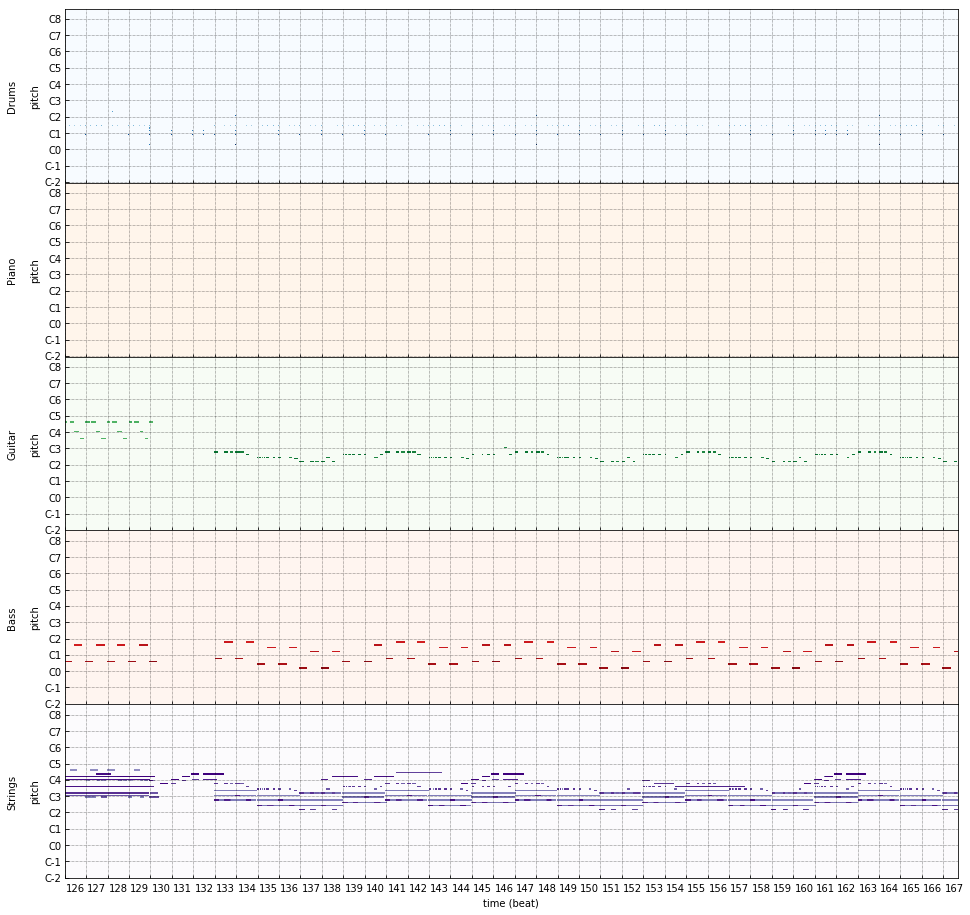

In [9]:
pypianoroll.load('b97c529ab9ef783a849b896816001748.npz').plot()
plt.xlim((3000,4000))

# Loading Data File (small)
### Data file is a list of sparse matrices
#### 5 tracks per song (Drums, Piano, Guitar, Bass and Strings)
#### pitch range: C-1 to G9 (128 pitches)
#### value in each "pixel" = volumn of the note
#### frequency = 24 per beat (quarter note)

In [8]:
datapath=Path('W:/Datasets/Music/lpd_5/lpd_5_cleansed')
datapath

PosixPath('W:/Datasets/Music/lpd_5/lpd_5_cleansed')

In [9]:
data = pickle.load(open('dataSparse_small1000.pkl','rb'))
data = data + pickle.load(open('dataSparse_small2000.pkl','rb'))
len(data) # number of songs
type(data),type(data[0])

3000

(list, scipy.sparse.csr.csr_matrix)

In [10]:
data_val=pickle.load(open('dataSparse_small100.pkl','rb'))  # validation set
len(data_val) # number of songs

100

# Define Pytorch Dataset
### Stack all songs together in the time dimension.
### Each data point is a single time slice because the autoencoder is ONLY responsible to encode chords, ie combination of pitches and instruments

In [11]:
class PianorollDS(Dataset):
    def __init__(self,data):
        self.data = scipy.sparse.vstack(data)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        return self.data[idx]

### The collate function is called to tell dataloader how to glue together a random batch

In [12]:
def sparse2dense_collate(xs):
    return torch.from_numpy(np.transpose(scipy.sparse.vstack(xs).toarray().reshape(-1,128,5),(0,2,1)))

# Normalization and Denormalization
## currently simply divide by 128

In [13]:
def velocityTransform(x):
#     return torch.log(127.5 - x.clamp(0,127).type(torch.float32))
#     return torch.log(0.5 + x.clamp(0,127).type(torch.float32))
    return x.clamp(0,127).type(torch.float32)/128.

In [14]:
velocity_range = np.array([0,127]).astype(np.uint8)
velocity_range_transformed = velocityTransform(torch.tensor(velocity_range))
velocity_range, velocity_range_transformed

(array([  0, 127], dtype=uint8), tensor([0.0000, 0.9922]))

In [15]:
def velocityDetransform(x):
#     return (127.5 - torch.exp( x.clamp(*velocity_range_transformed.flip(0).numpy()) ) +0.5).type(torch.uint8)
#     return (torch.exp( x.clamp(*velocity_range_transformed.numpy()) )).type(torch.uint8)
#     # +0.5 to round to closest int, so that 1==Detrans(Trans(1)) instead of 0 which could be
#     # good because we want 0s if signal is weak. So revise if needed.
    return (( x.clamp(*velocity_range_transformed.numpy())*128. ) +0.5).type(torch.uint8)

In [16]:
velocityDetransform(velocity_range_transformed)

tensor([  0, 127], dtype=torch.uint8)

In [17]:
velocityDetransform(velocityTransform(torch.tensor(126).type(torch.uint8)))

tensor(126, dtype=torch.uint8)

# Define Autoencoder

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder=nn.Sequential(                     #(5,128)
                            nn.Conv1d(5,40,12,groups=5), #(40,117)
                            nn.ReLU(),
                            nn.Conv1d(40,16,18,stride=11,groups=1), # (16,10), (kernel_size = 116-(out_size-1)*stride+1), 116=in_size-1
                            nn.ReLU(),
                            nn.Conv1d(16,24,10,stride=1,groups=1), # (24,1), (kernel_size = 9-(out_size-1)*stride+1), 9=in_size-1
                            nn.Sigmoid(),
                            )
        self.decoder=nn.Sequential(
                            nn.ConvTranspose1d(24,16,10,stride=1),
                            nn.ReLU(),
                            nn.ConvTranspose1d(16,40,18,stride=11),
                            nn.ReLU(),
                            nn.ConvTranspose1d(40,5,12),
#                             SigmoidRange(-0.7, 5),
                            SigmoidRange(-0.1, 1.1),
#                             nn.Tanh(),
#                             nn.ReLU()
        )

    def forward(self, x):
        encoding = self.encoder(x)
        x = self.decoder(encoding)
        return encoding.view(-1,3,8), x
    
    def get_encoder(self):
        return self.encoder

In [27]:
autoencoder=Autoencoder().cuda()

# Load saved model

In [29]:
autoencoder.load_state_dict(torch.load('conv_AE.pth'))

# Train a bit more

In [30]:
loss_fn = nn.MSELoss().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-4, weight_decay=1e-5)
# optimizer_cosine = optim.lr_scheduler.LambdaLR(optimizer, lambda i_batch: np.cos(i_batch/))

=============== Cycle 0 ==============
[[epoch 0]]:  training   batch 178/178
  average training   loss/batch = 0.001562649264455553
          validation batch 117/117
                average validation loss/batch = 24.806305926070255


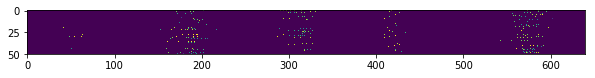

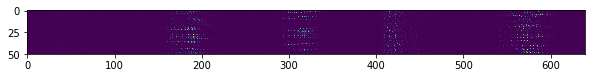

[[epoch 1]]:  training   batch 178/178
  average training   loss/batch = 0.0014535913151019159
          validation batch 117/117
                average validation loss/batch = 24.698672058235886


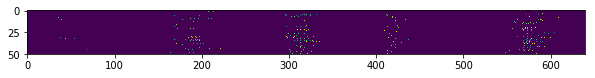

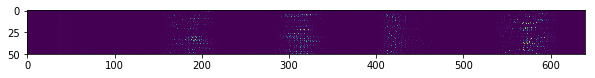

[[epoch 2]]:  training   batch 180/180
  average training   loss/batch = 0.0014274103554069168
          validation batch 117/117
                average validation loss/batch = 24.50154685974121


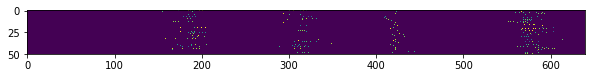

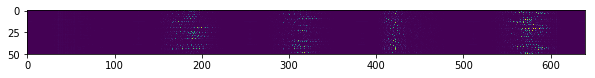

[[epoch 3]]:  training   batch 172/172
  average training   loss/batch = 0.001436096773791495
          validation batch 117/117
                average validation loss/batch = 24.576316523755718


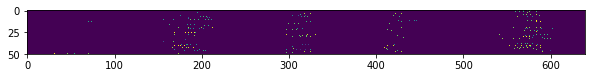

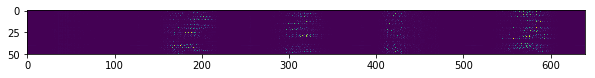

[[epoch 4]]:  training   batch 179/179
  average training   loss/batch = 0.001469272697427669
          validation batch 117/117
                average validation loss/batch = 24.436025652111088


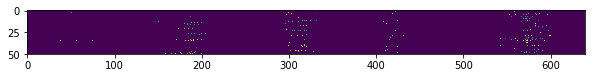

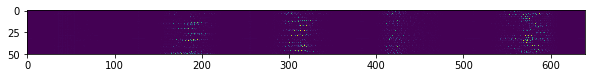

[[epoch 5]]:  training   batch 179/179
  average training   loss/batch = 0.0016016619873113471
          validation batch 117/117
                average validation loss/batch = 24.381297983674923


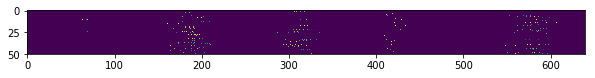

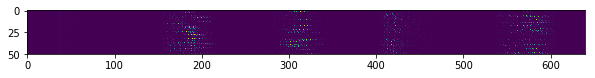

[[epoch 6]]:  training   batch 188/188
  average training   loss/batch = 0.0014720643899017113
          validation batch 117/117
                average validation loss/batch = 24.20485609005659


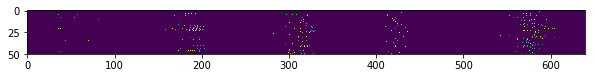

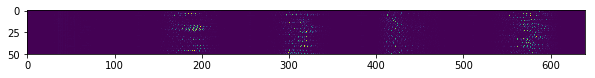

[[epoch 7]]:  training   batch 190/190
  average training   loss/batch = 0.0014625025545491983
          validation batch 117/117
                average validation loss/batch = 24.554131353003346


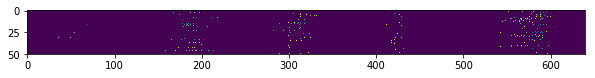

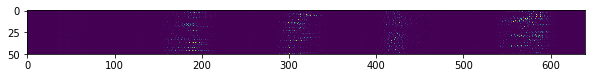

[[epoch 8]]:  training   batch 178/178
  average training   loss/batch = 0.0013560440922365262
          validation batch 117/117
                average validation loss/batch = 24.410823756812984


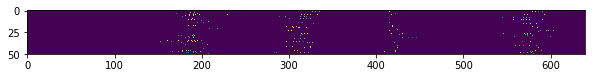

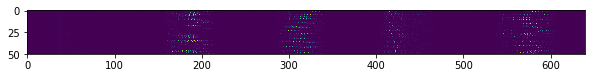

[[epoch 9]]:  training   batch 181/181
  average training   loss/batch = 0.0014157071272271444
          validation batch 117/117
                average validation loss/batch = 24.387311136620678


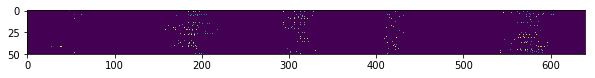

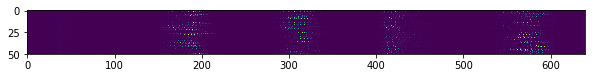

[[epoch 10]]:  training   batch 178/178
  average training   loss/batch = 0.001300240458078222
          validation batch 117/117
                average validation loss/batch = 24.43035104539659


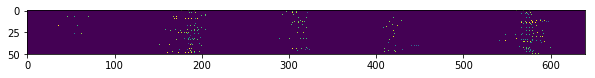

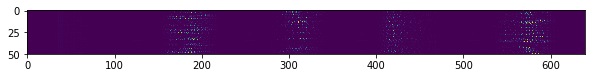

[[epoch 11]]:  training   batch 183/183
  average training   loss/batch = 0.0015020702839600014
          validation batch 117/117
                average validation loss/batch = 24.376999781681942


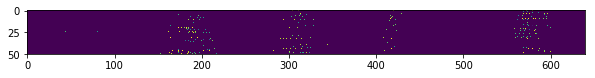

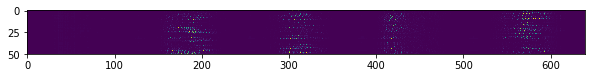

[[epoch 12]]:  training   batch 185/185
  average training   loss/batch = 0.0013258589828084853
          validation batch 117/117
                average validation loss/batch = 24.372046429886776


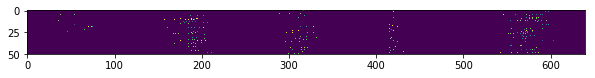

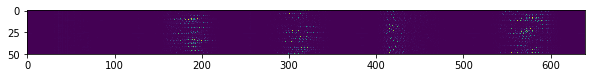

[[epoch 13]]:  training   batch 180/180
  average training   loss/batch = 0.0015050528085945795
          validation batch 117/117
                average validation loss/batch = 24.491236222095978


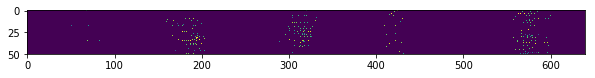

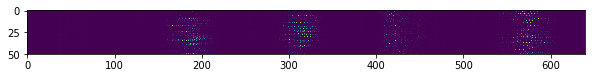

[[epoch 14]]:  training   batch 181/181
  average training   loss/batch = 0.0014503461402681403
          validation batch 117/117
                average validation loss/batch = 24.38882351736737


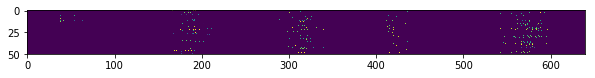

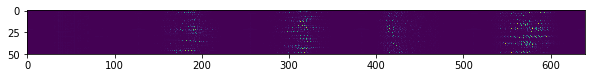

[[epoch 15]]:  training   batch 188/188
  average training   loss/batch = 0.0013706257264625202
          validation batch 117/117
                average validation loss/batch = 24.3279118171105


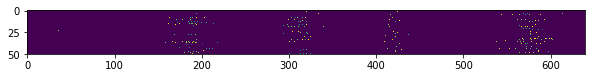

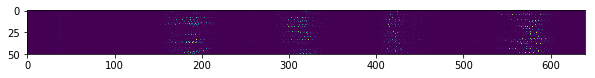

[[epoch 16]]:  training   batch 185/185
  average training   loss/batch = 0.001276280836680451
          validation batch 117/117
                average validation loss/batch = 24.213757588313175


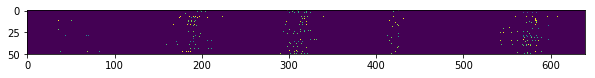

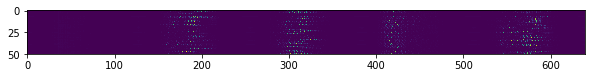

[[epoch 17]]:  training   batch 176/176
  average training   loss/batch = 0.0014870645318296738
          validation batch 117/117
                average validation loss/batch = 24.159098111666164


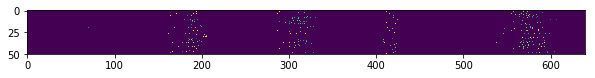

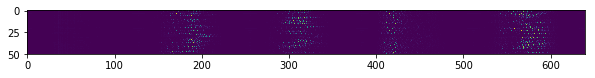

[[epoch 18]]:  training   batch 188/188
  average training   loss/batch = 0.0014115994972018326
          validation batch 117/117
                average validation loss/batch = 24.116238047933987


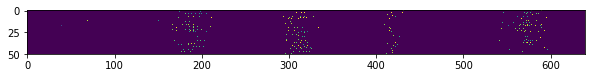

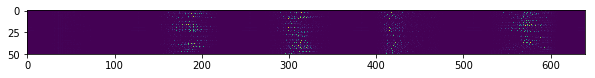

[[epoch 19]]:  training   batch 188/188
  average training   loss/batch = 0.0013761748219196228
          validation batch 117/117
                average validation loss/batch = 24.14774925688393


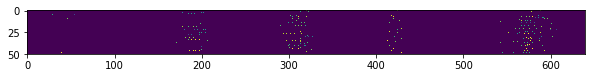

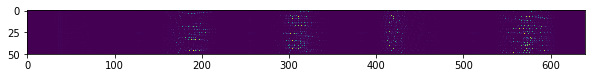

In [31]:
num_epochs = 20
epoch_size = 150 # number of songs to load each epoch
batch_size = 1028*8 #after vstack, number of timestep
dl_num_worker = 32

# loading last 1400 songs in the validation data loader using the same batch size.
# want to use the same set of 1400 songs because we want to measure performance consistently.
# validation_data=data[-1400:-1350]
ds_val=PianorollDS(data_val[:100])
dl_val = DataLoader(ds_val, batch_size=batch_size, collate_fn=sparse2dense_collate,
                        shuffle=True, num_workers=dl_num_worker)

# normally, one epoch is going through the entire training dataset once.
# however, our entire dataset is too huge to load batches efficiently.
# so, one epoch here means to go through a `epoch_size` number of songs, and
# for the next epoch, we load another `epoch_size` number of songs.
# And for each epoch, we load batches as usual.
for j in range(1):
    print(f'=============== Cycle {j} ==============')
    for i_epoch in range(num_epochs):
        loss_cum=0
        ds = PianorollDS(data[i_epoch*epoch_size : (1+i_epoch)*epoch_size])
        dl = DataLoader(ds, batch_size=batch_size, collate_fn=sparse2dense_collate,
                        shuffle=True, num_workers=dl_num_worker)
        num_batches = len(ds)//batch_size

        for i_batch, di in enumerate(iter(dl)): # enumerate(iterator) returns a tuple: (ith loop, actual next(iterator))
#             autoencoder.train()
            di=velocityTransform(di.cuda())
            optimizer.zero_grad()
            encoding,preds=autoencoder(di)
            loss=loss_fn(preds,di)
            loss.backward()
            loss_cum+=loss.item()
            optimizer.step()
            print('[[epoch '+str(i_epoch)+']]:  training   batch '+ str(i_batch) + '/' + str(num_batches), end='\r') # end='\r' means continuesly refreshing same line of output
    #     if i_batch %100 == 99:
        print('\n  average training   loss/batch =', loss_cum/num_batches)
        loss_cum=0
        # starting validation: load one batch each loop after one epoch of traing loop
        for i_batch_val,di_val in enumerate(iter(dl_val)):
#             autoencoder.eval()
            di_val=velocityTransform(di_val.cuda())
            encoding,preds=autoencoder(di_val)
            loss=loss_fn(velocityDetransform(preds).type(torch.float),velocityDetransform(di_val).type(torch.float))
            loss_cum+=loss.item()
            print('          validation batch '+ str(i_batch_val) + '/' + str(len(ds_val)//batch_size), end='\r')
        print('\n                average validation loss/batch =', loss_cum/(len(ds_val)//batch_size))
        plt.imshow(velocityDetransform(di_val.cpu()).numpy()[:50].reshape(-1,640))
        plt.show()
        plt.imshow(velocityDetransform(preds.detach().cpu()).numpy()[:50].reshape(-1,640))
        plt.show()
        loss_cum=0

In [39]:
# torch.save(autoencoder.state_dict(), './conv_AE.pth')

# Encoding function with the trained model:
### Takes a song (sparse matrix) and feed to model, extract the middle encoding (3 chanel, 8 pixel tall, [timesteps] long), fold the time dimension to make things square-ish, then visualize by plotting as RGB image

In [80]:
def encode_song(sparse_song, num_fold=32, staff_height=8):
    autoencoder.eval()

    enc,_ = autoencoder(velocityTransform(torch.from_numpy(
        sparse_song.toarray().reshape(-1,128,5).transpose(0,2,1)
        )).cuda())

    # enc.shape
    song = enc.detach().cpu().numpy().transpose((2,0,1))
    # song.shape

    # num_fold = 32
    img_height = staff_height*num_fold
    song_folded = np.pad(song,((0,0),(0,num_fold-song.shape[1]%num_fold),(0,0)),'edge').reshape(staff_height*num_fold,-1,3)
    # song_folded.shape


    plt.imshow(song_folded)
    plt.show()

# Pick 30 songs to visualize their encoding

==== song 2500 ====


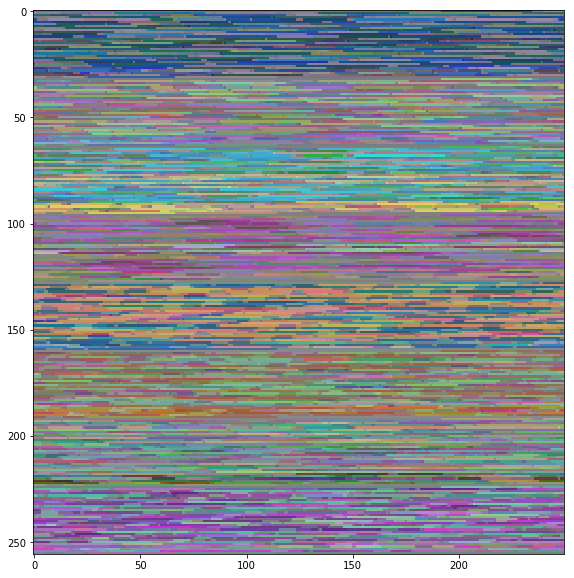

==== song 2501 ====


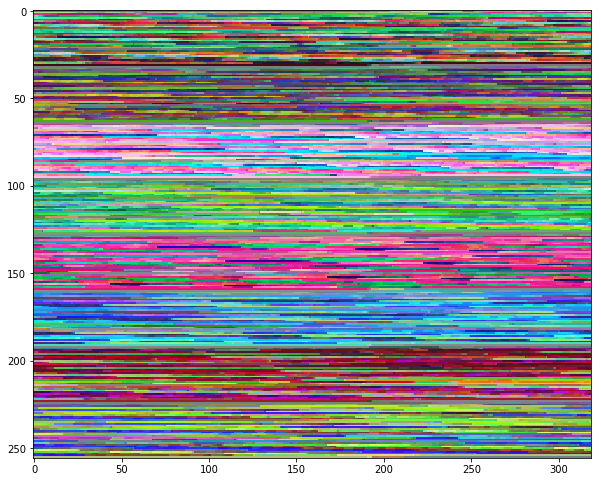

==== song 2502 ====


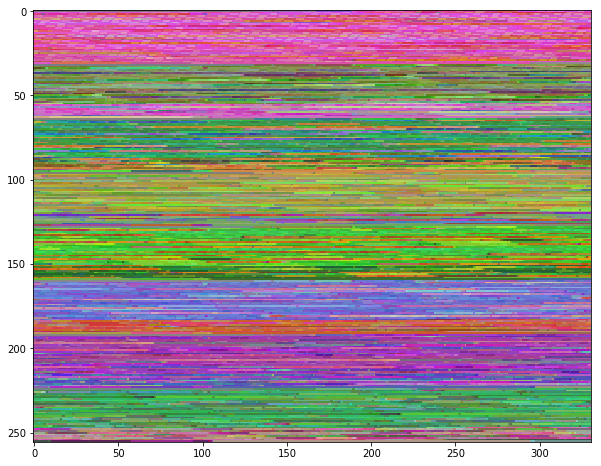

==== song 2503 ====


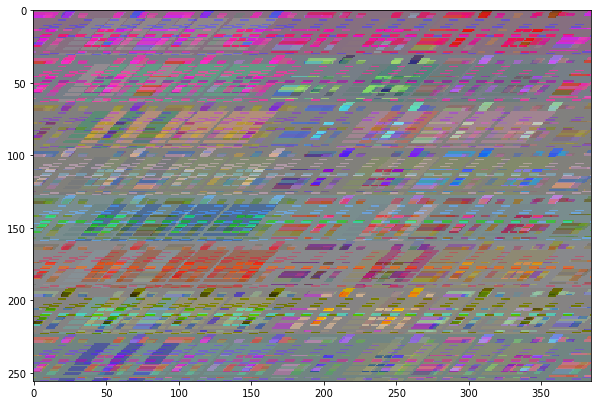

==== song 2504 ====


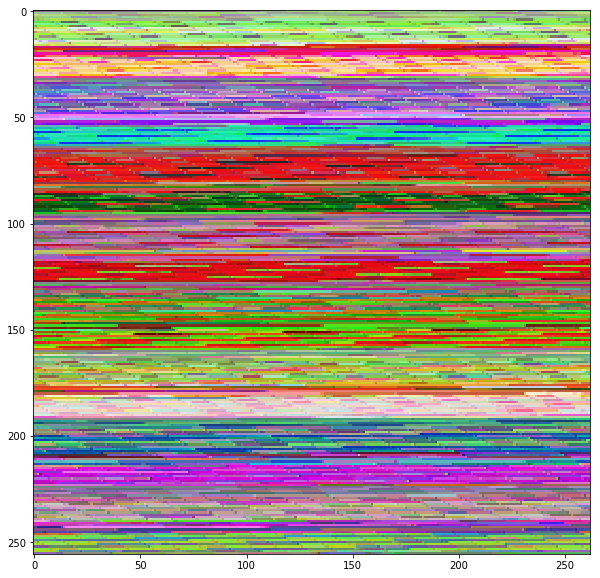

==== song 2505 ====


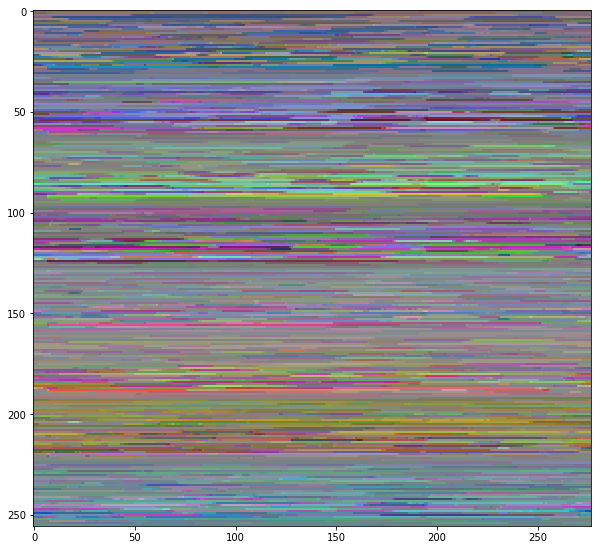

==== song 2506 ====


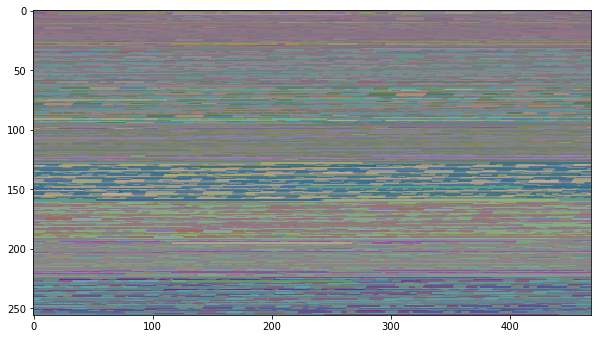

==== song 2507 ====


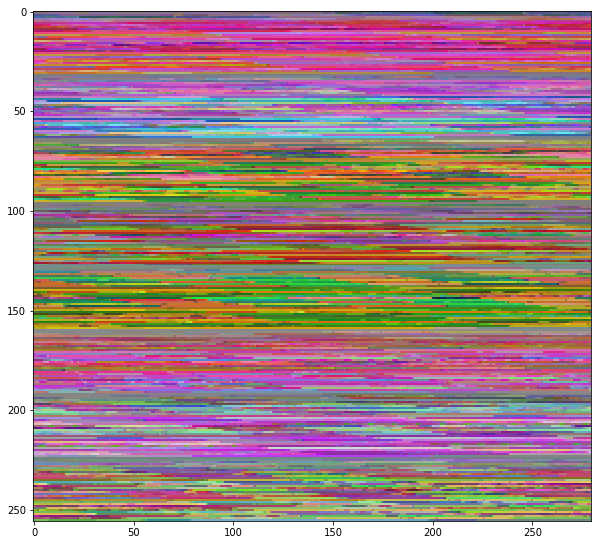

==== song 2508 ====


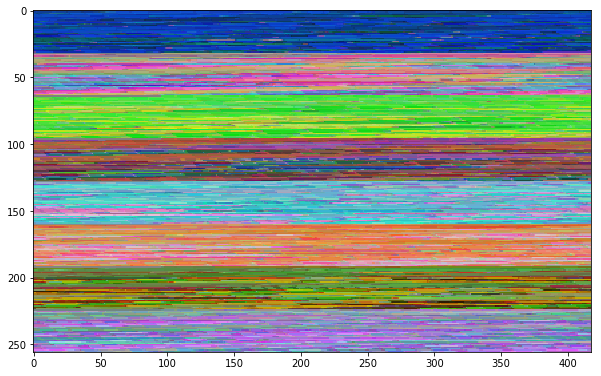

==== song 2509 ====


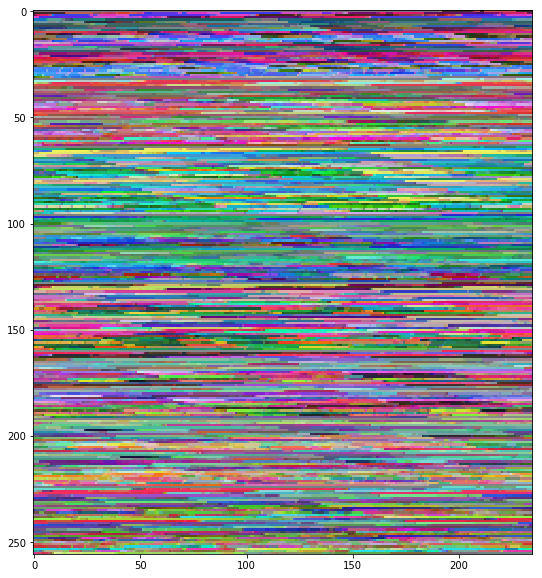

==== song 2510 ====


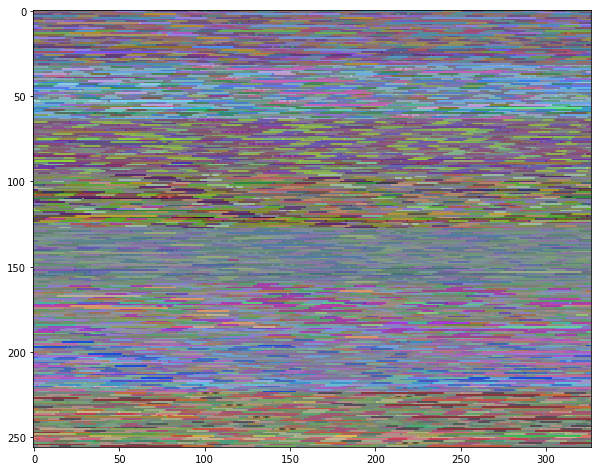

==== song 2511 ====


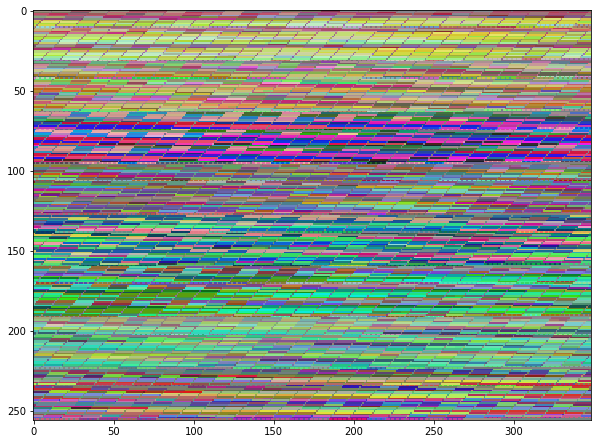

==== song 2512 ====


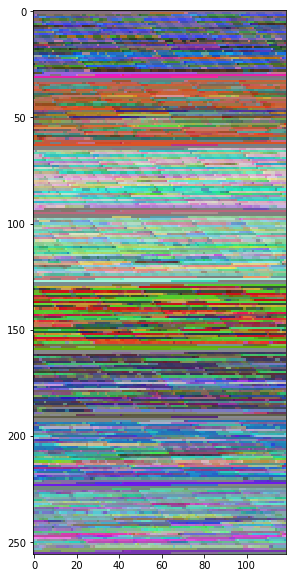

==== song 2513 ====


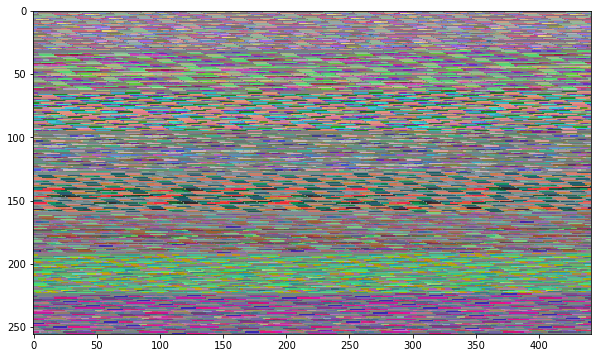

==== song 2514 ====


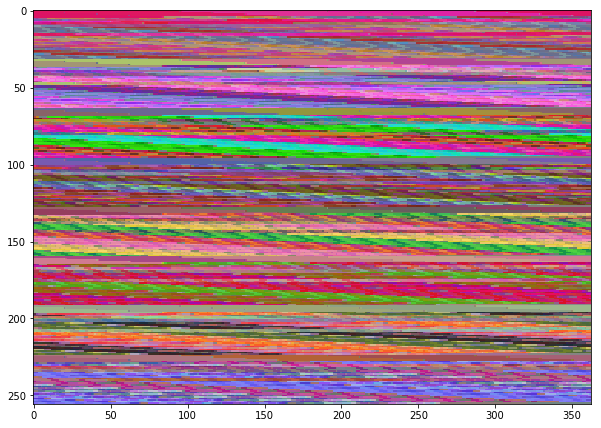

==== song 2515 ====


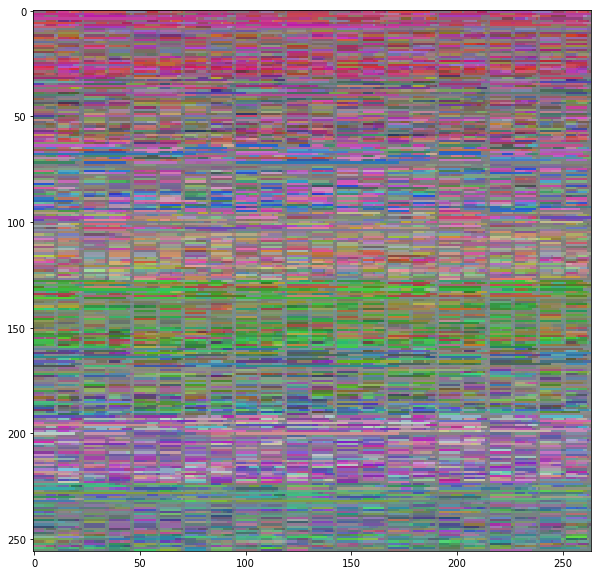

==== song 2516 ====


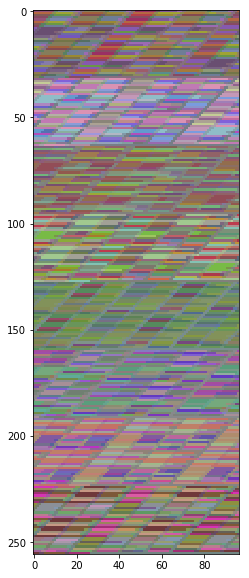

==== song 2517 ====


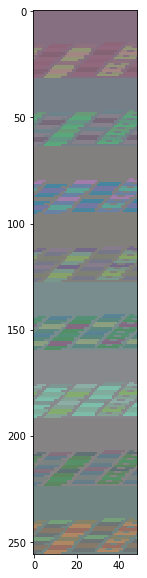

==== song 2518 ====


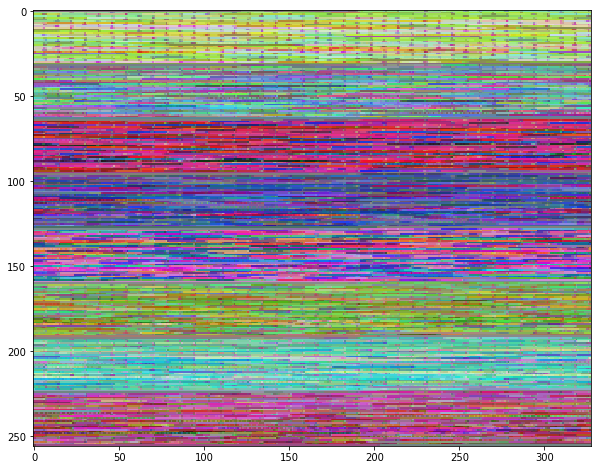

==== song 2519 ====


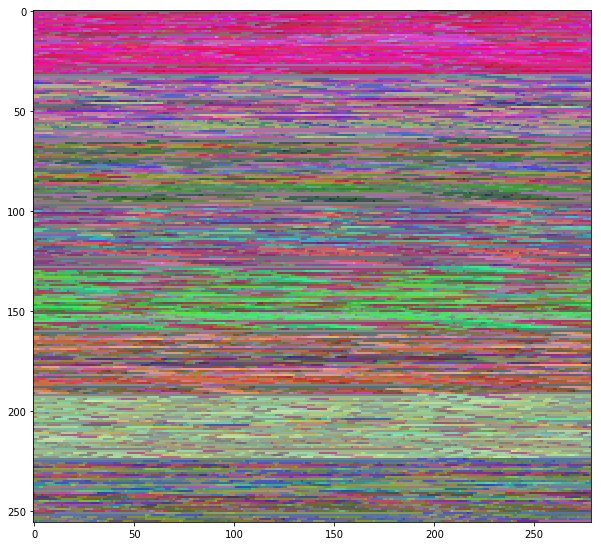

==== song 2520 ====


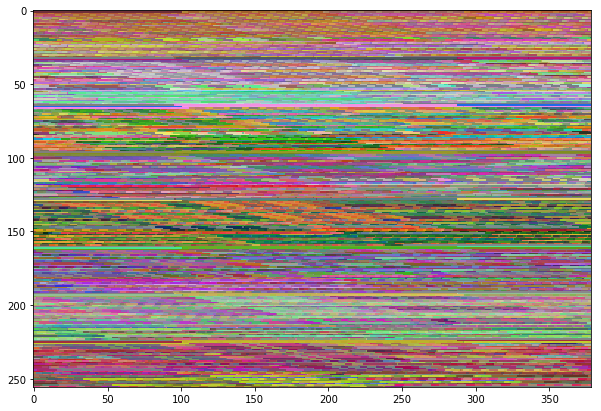

==== song 2521 ====


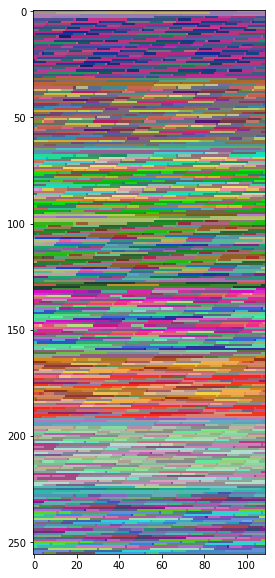

==== song 2522 ====


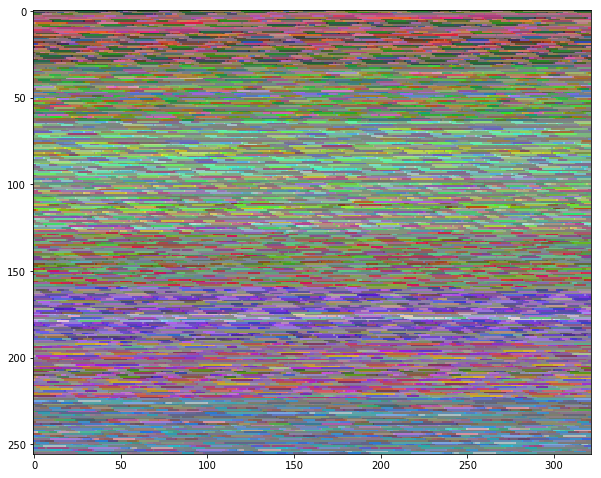

==== song 2523 ====


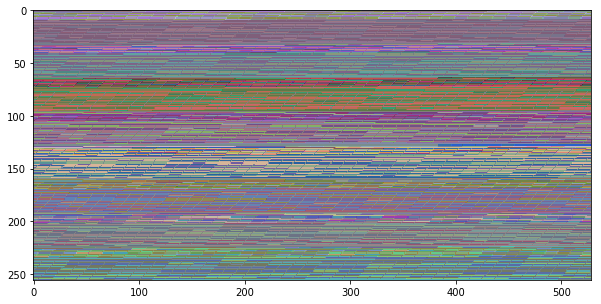

==== song 2524 ====


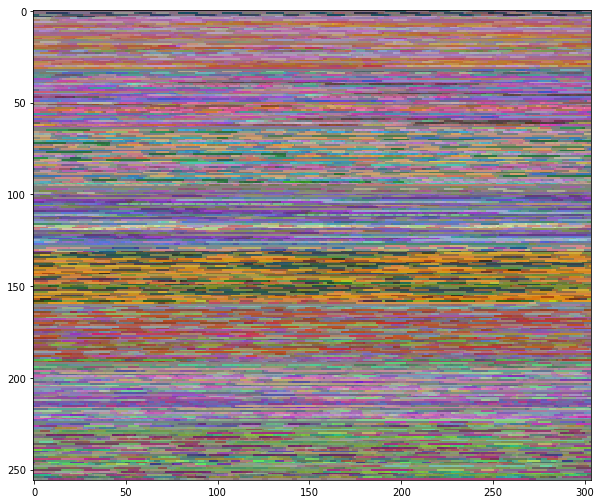

==== song 2525 ====


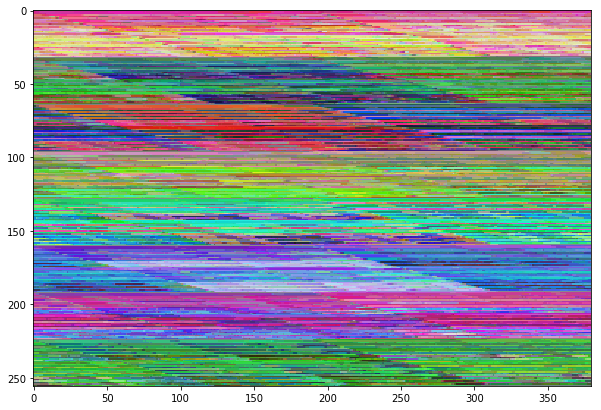

==== song 2526 ====


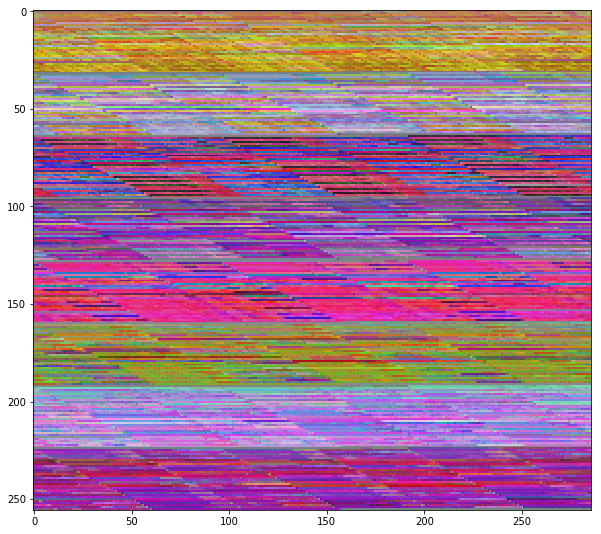

==== song 2527 ====


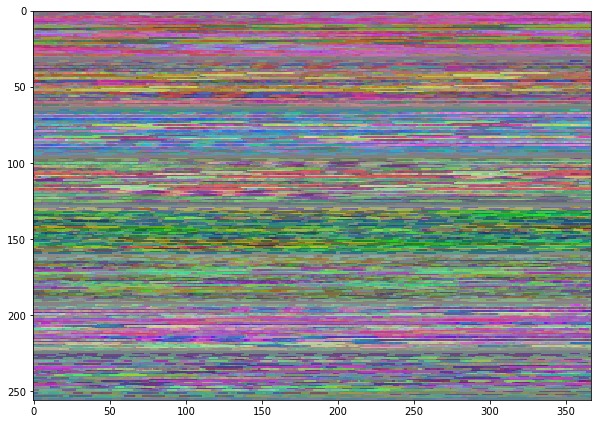

==== song 2528 ====


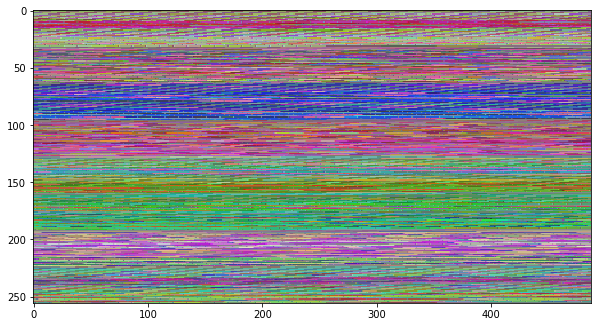

==== song 2529 ====


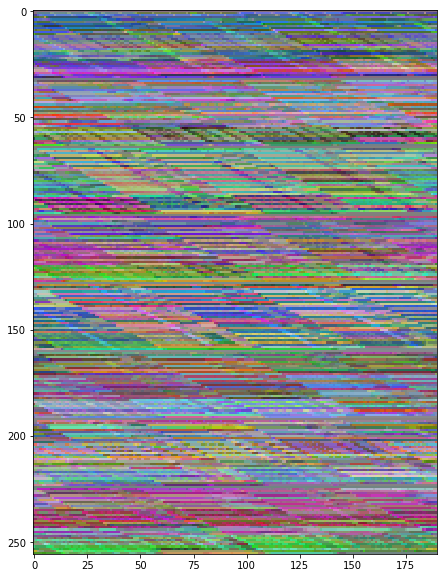

In [84]:
for i in range(2500,2530):
    print(f'==== song {i} ====')
    encode_song(data[i])
    